In [3]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
testset_name = "finals_separated_networks_demands_signal"
results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

color_scheme = {
    "GNN": "#1f77b4",         # Blue
    "GNN_decentralized": "#2ca02c", # Green
}

linestyle_scheme = {
    "GNN": "-",         # Solid
    "GNN_decentralized": "-.", # Dashed-dotted
}

architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_transshipment',
    "GNN_decentralized": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_decentralized_transshipment',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

sample_size = 8192
store_underage_cost = [2, 6, 10]

dfs = []

for arch_name, path_fn in architectures.items():
    path = path_fn(testset_name)
    search_conditions = {
        'store_underage_cost': [store_underage_cost],
    }
    df = results_interpretor.make_table(
        {1: path},
        search_conditions,
        default_condition_setter,
        custom_data_filler,
        sort_by=sort_by,
        pick_row_from_run_by=pick_row_from_run_by,
        test_loss_limit=100
    )
    if df.empty:
        continue
    df.insert(2, 'Architecture Class', arch_name)
    df.insert(1, 'hyperparam_name', arch_name)
    dfs.append(df)

if len(dfs) == 0:
    raise ValueError("No data found.")

df = pd.concat(dfs, ignore_index=True)

In [5]:
import numpy as np

test_loss_column = 'Test Loss'
test_loss_filename = 'finals_separated_networks_demands_signal_test_loss.txt'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) +"/"+ test_loss_filename
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

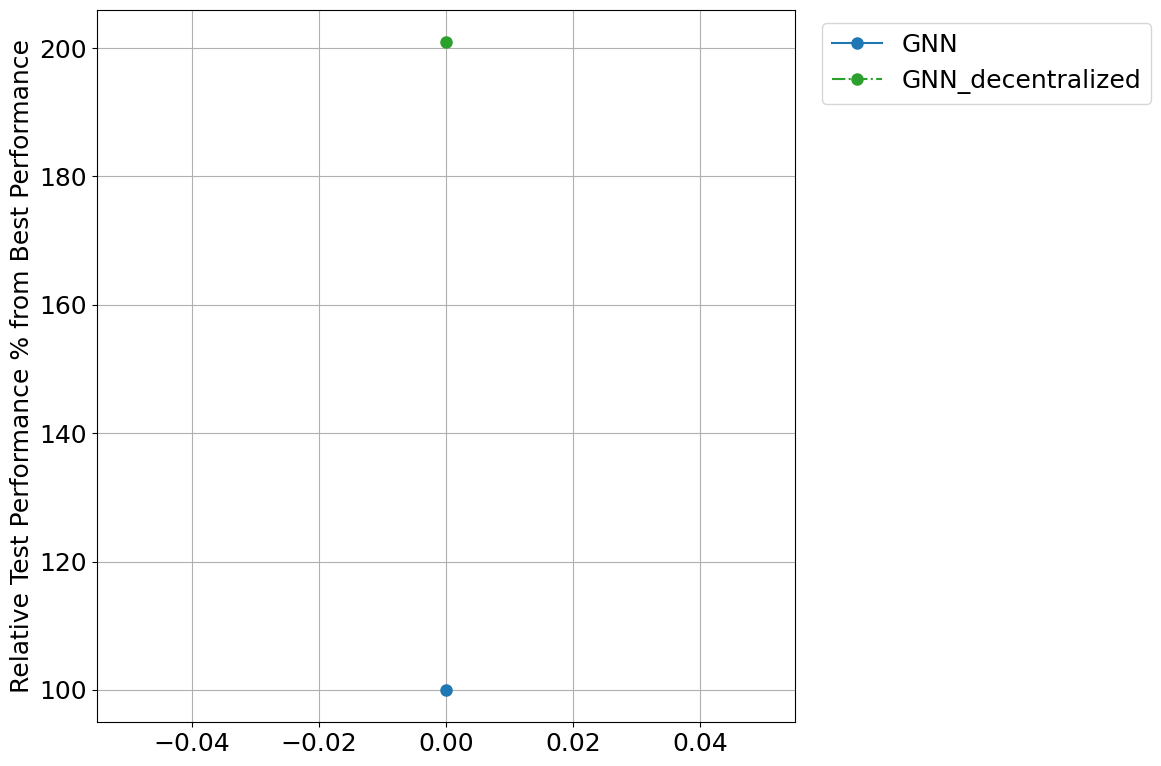

In [6]:
performance_loss = 'Test Loss'
df['Relative Test Performance %'] = np.nan
best_test_loss = df[performance_loss].min()
df['Relative Test Performance %'] = (df['Test Loss'] / best_test_loss) * 100

FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

for arch in df['Architecture Class'].unique():
    arch_data = df[df['Architecture Class'] == arch]
    if not arch_data.empty:
        plt.plot(
            np.array(arch_data['Relative Test Performance %']),
            marker="o",
            color=color_scheme[arch],
            linestyle=linestyle_scheme[arch],
            markersize=8,
            label=arch
        )

plt.ylabel('Relative Test Performance % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

plt.legend(bbox_to_anchor=(1.02, 1),
          loc='upper left', 
          fontsize=FONTSIZE)

plt.tight_layout()
plt.show()

In [11]:
print(df.to_string())

   # of stores    hyperparam_name store_underage_cost Architecture Class  Learning Rate  Train Loss  Dev Loss  # of runs                                                                                                                                                                                                                                                                                      path  Test Loss  Relative Test Performance %
0            1                GNN          (2, 6, 10)                GNN          0.001    3.678431  3.691520          9                /user/ml4723/Prj/NIC/ray_results/finals_separated_networks_demands_signal/GNN_transshipment/run_2025-05-22_11-23-01/run_a6358_00001_1_config=finals_separated_networks_demands_signal,early_stop_check_epochs=10,learning_rate=0.0010,repeats=1,stop_i_2025-05-22_11-23-01   3.695657                   100.000000
1            1  GNN_decentralized          (2, 6, 10)  GNN_decentralized          0.010    5.193326  5.167549     

In [7]:
df_to_print = df.drop(columns=['path', '# of runs', 'Learning Rate'])
print(df_to_print.to_string())

   # of stores    hyperparam_name store_underage_cost Architecture Class  Train Loss  Dev Loss  Test Loss  Relative Test Performance %
0            1                GNN          (2, 6, 10)                GNN    3.678431  3.691520   3.695657                   100.000000
1            1  GNN_decentralized          (2, 6, 10)  GNN_decentralized    5.193326  5.167549   7.424253                   200.891319


In [6]:
mode = "test"
setting_names = ['finals_separated_networks_demands_signal']

models = []
for _, row in df.iterrows():
    models.append(str(row['path']) + '/model.pt')

gpus = [0, 1, 2, 3]

import nest_asyncio
import asyncio

nest_asyncio.apply()

async def run_main_run(model_path, setting_name, gpu_idx, semaphore):
    async with semaphore:
        try:
            hyperparam_name = model_path.split('/')[7]
            print(f"Running main_run.py for path {model_path}")
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                mode,
                setting_name,
                hyperparam_name,
                str(model_path),
                str(gpus[gpu_idx])
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            process = await asyncio.create_subprocess_exec(
                *cmd,
                env=env,
                cwd="/user/ml4723/Prj/NIC/",
                stdout=asyncio.subprocess.PIPE,
                stderr=asyncio.subprocess.PIPE
            )
            stdout, stderr = await process.communicate()
            if process.returncode != 0:
                print(f"Error running main_run.py for path {model_path}: {stderr.decode()}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {model_path}: {e}")

async def main():
    max_concurrent = 6 * len(gpus)
    semaphore = asyncio.Semaphore(max_concurrent)
    tasks = []
    gpu_idx = 0
    for setting_name in setting_names:
        for path in models:
            tasks.append(run_main_run(path, setting_name, gpu_idx, semaphore))
            gpu_idx = (gpu_idx + 1) % len(gpus)
    await asyncio.gather(*tasks)

await main()


Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_separated_networks_demands_signal/GNN_transshipment/run_2025-05-22_11-23-01/run_a6358_00001_1_config=finals_separated_networks_demands_signal,early_stop_check_epochs=10,learning_rate=0.0010,repeats=1,stop_i_2025-05-22_11-23-01/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_separated_networks_demands_signal/GNN_decentralized_transshipment/run_2025-05-22_11-23-33/run_b981a_00000_0_config=finals_separated_networks_demands_signal,early_stop_check_epochs=10,learning_rate=0.0100,repeats=1,stop_i_2025-05-22_11-23-34/model.pt


In [1]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name, is_profit=False):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                "0",
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{setting_name}/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit_or_cost = []
    w_holding_by_warehouse_all = []
    return_data = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 100
            start_step = 60
        else:
            num_steps = 500
            start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        s_underage = relevant_data['s_underage_costs'].sum()
        s_holding = relevant_data['s_holding_costs'].sum()
        
        # Split warehouse holding costs by warehouse
        w_holding_costs = []
        for i in range(n_warehouses):
            w_holding_costs.append(relevant_data[f'w_{i}_holding_costs'].sum())
        w_holding = sum(w_holding_costs)
        
        avg_s_underage.append(s_underage)
        avg_s_holding.append(s_holding)
        w_holding_by_warehouse_all.append(w_holding_costs)
        avg_w_holding.append(w_holding)
        
        if is_profit:
            # For profit: negate underage (revenue) and subtract costs
            profit = -s_underage - s_holding - w_holding
            avg_profit_or_cost.append(profit)
        else:
            # For loss: sum all costs
            cost = s_underage + s_holding + w_holding
            avg_profit_or_cost.append(cost)

        return_data.append(data)

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    
    # Add individual warehouse holding costs
    for i in range(n_warehouses):
        df_copy[f'w_{i}_holding'] = [x[i] for x in w_holding_by_warehouse_all]
        
    metric_name = 'avg_profit' if is_profit else 'avg_lost_sales'
    df_copy[metric_name] = avg_profit_or_cost
    df = df_copy

    # Calculate relative metric as percentage of best value
    if is_profit:
        best_value = df[metric_name].max()
        df['relative_metric'] = df[metric_name] / best_value * 100
    else:
        best_value = df[metric_name].min()
        df['relative_metric'] = df[metric_name] / best_value * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'] + 
                        [f'w_{i}_holding' for i in range(n_warehouses)])
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()
    
    metric_title = 'Profit' if is_profit else 'Loss'
    titles = [f'{metric_title} (% of {"maximum" if is_profit else "minimum"})', 
              'Store Revenue(1e7)' if is_profit else 'Store Lost Sales(1e7)', 
              'Store Holding Cost(1e7)', 
              'Total Warehouse Holding Cost(1e7)', 
              'Individual Warehouse Holding Costs(1e7)']
    y_values = ['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    # Create a single legend at the top
    legend_lines = []
    legend_labels = []
    for arch in df['Architecture Class'].unique():
        legend_lines.append(plt.Line2D([0], [0], color=color_scheme[arch], 
                                     linestyle=linestyle_scheme[arch], marker='o', markersize=10))
        legend_labels.append(arch)
    
    fig.legend(legend_lines, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=len(legend_labels))

    for i, (ax, title, y_value) in enumerate(zip(axes[:-1], titles[:-1], y_values)):
        for arch in df['Architecture Class'].unique():
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                if y_value != 'relative_metric':
                    plot_values = plot_values / 1e7
                x_values = np.ones_like(plot_values)
                ax.plot(x_values, plot_values, marker='o', markersize=10,
                       color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.grid(True)
        ax.set_xticks([])

    # Plot individual warehouse holding costs
    for arch in df['Architecture Class'].unique():
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_holding'].columns:
                plot_values = plot_data[f'w_{i}_holding'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-1].plot(x_values, plot_values, marker='o', markersize=10,
                            color=color_scheme[arch], linestyle=linestyle_scheme[arch])

    axes[-1].set_ylabel('Warehouse Holding Cost(1e7)')
    axes[-1].set_title('Individual Warehouse Holding Costs(1e7)')
    axes[-1].grid(True)
    axes[-1].set_xticks(range(1, n_warehouses + 1))
    axes[-1].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    return return_data

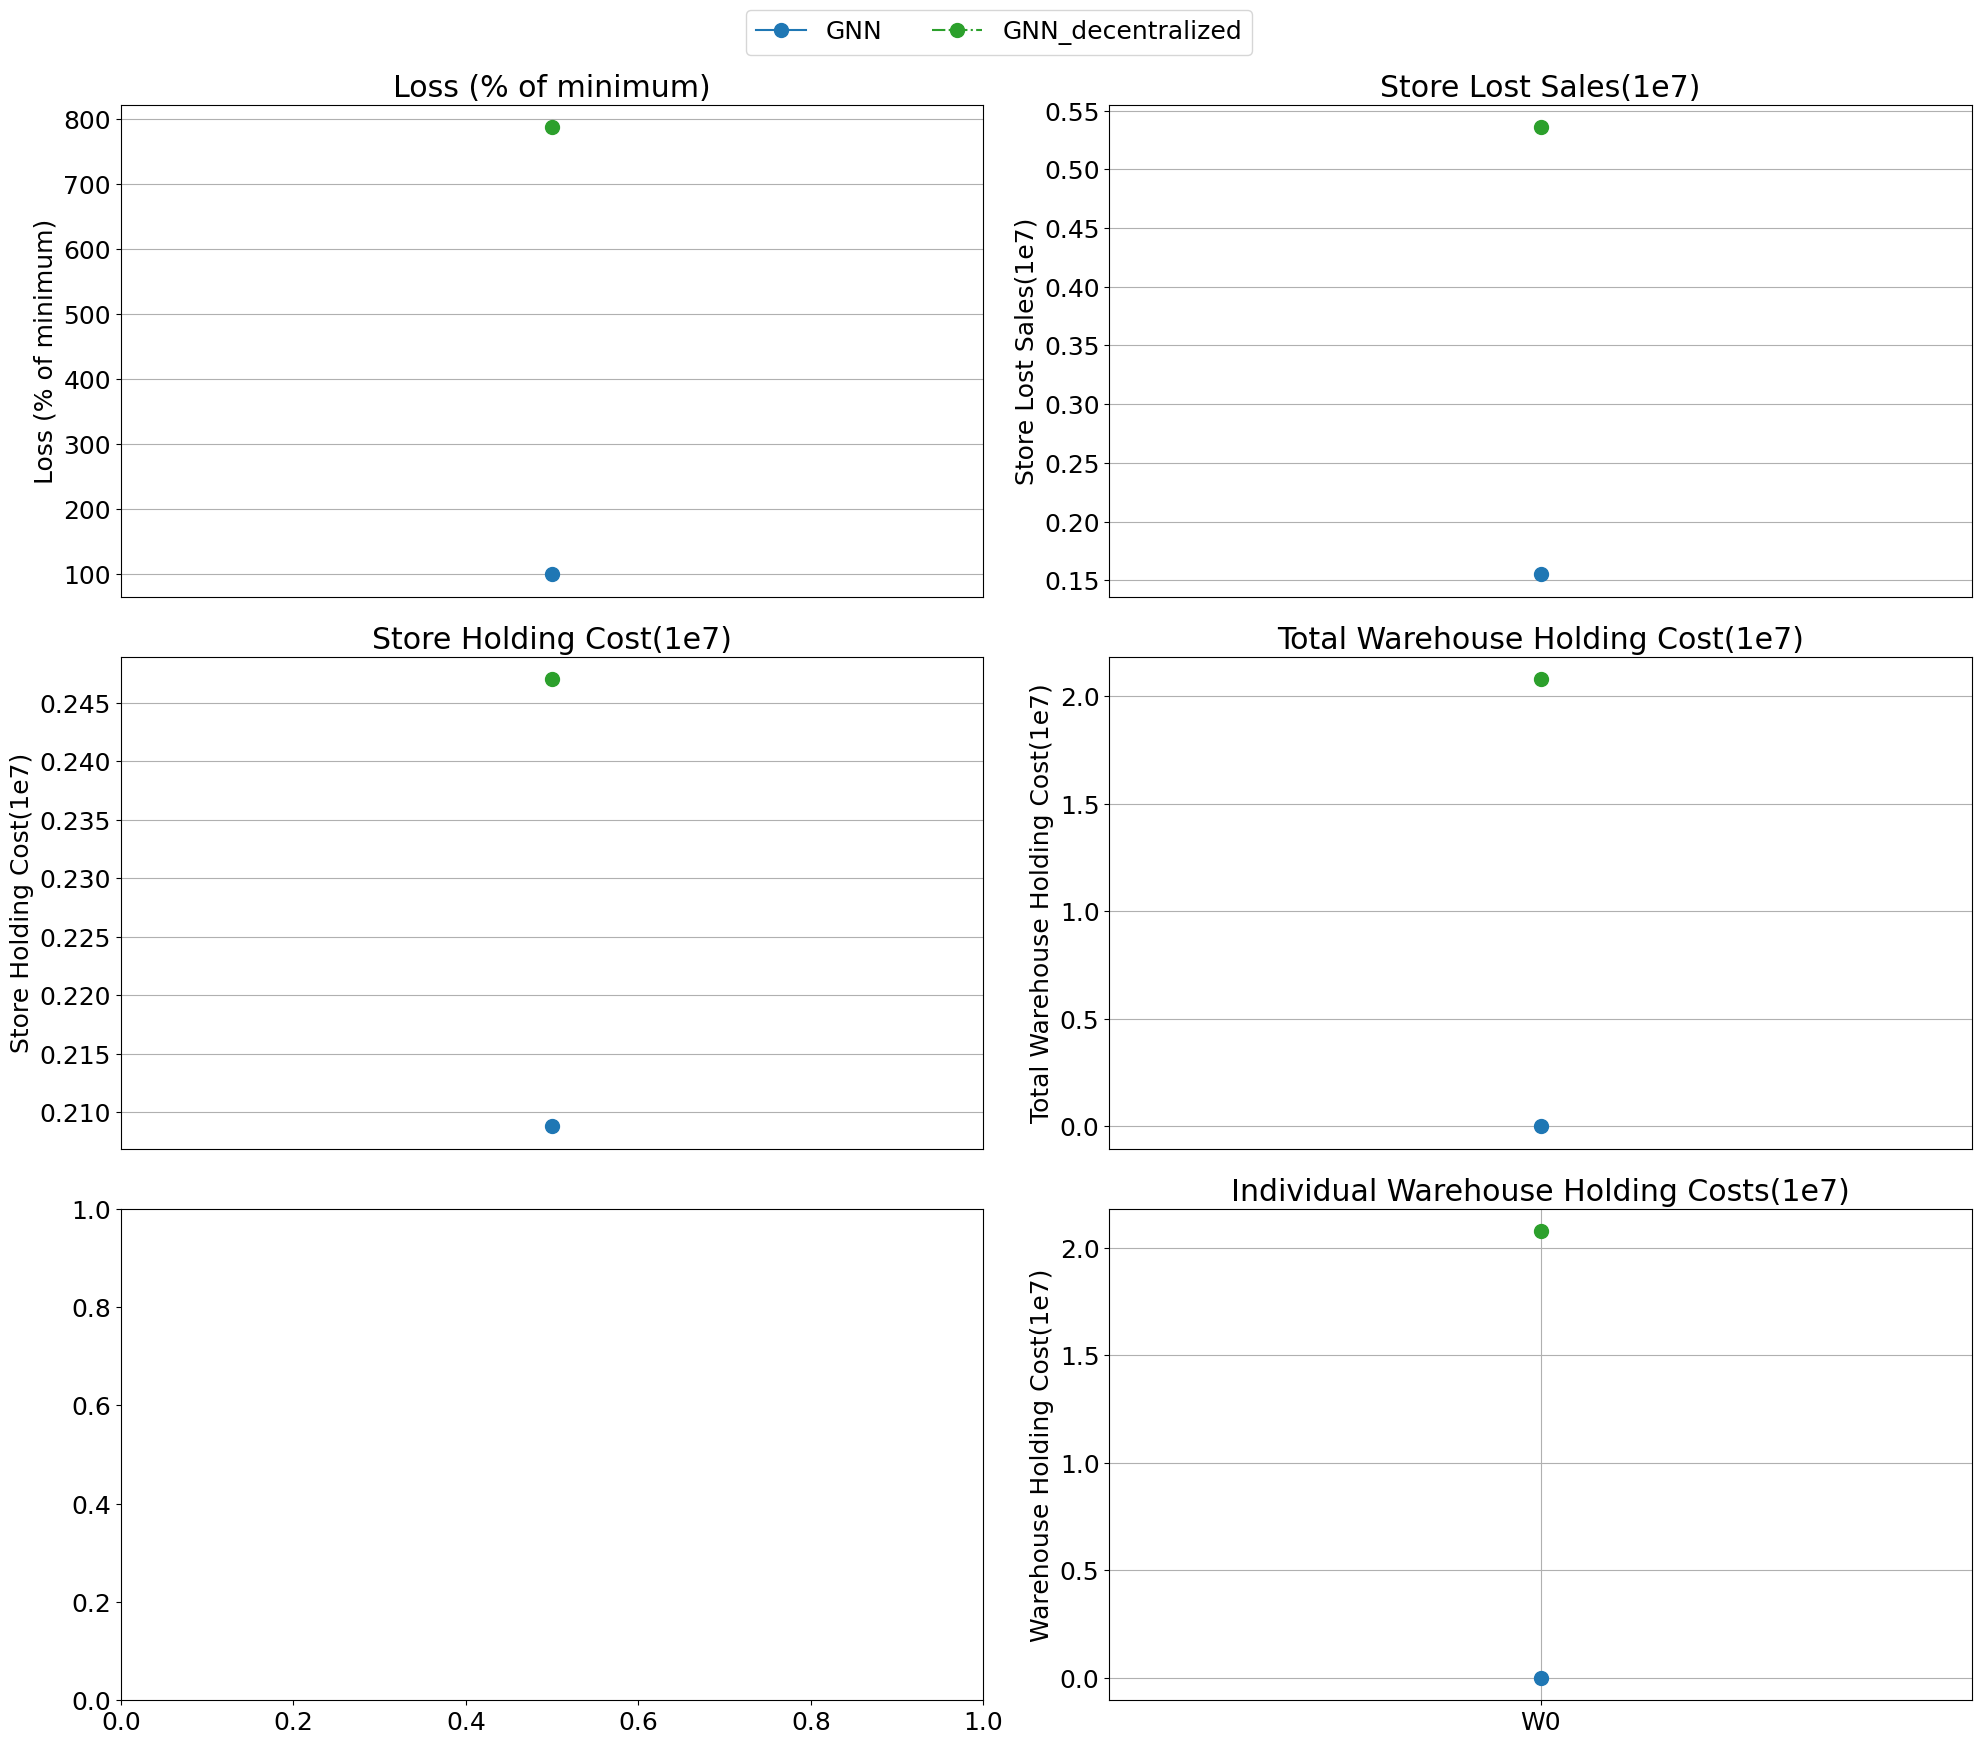

In [8]:
data = collect_data_and_plot(df, 3, 1, sample_size, "test_on_dev", "finals_separated_networks_demands_signal")

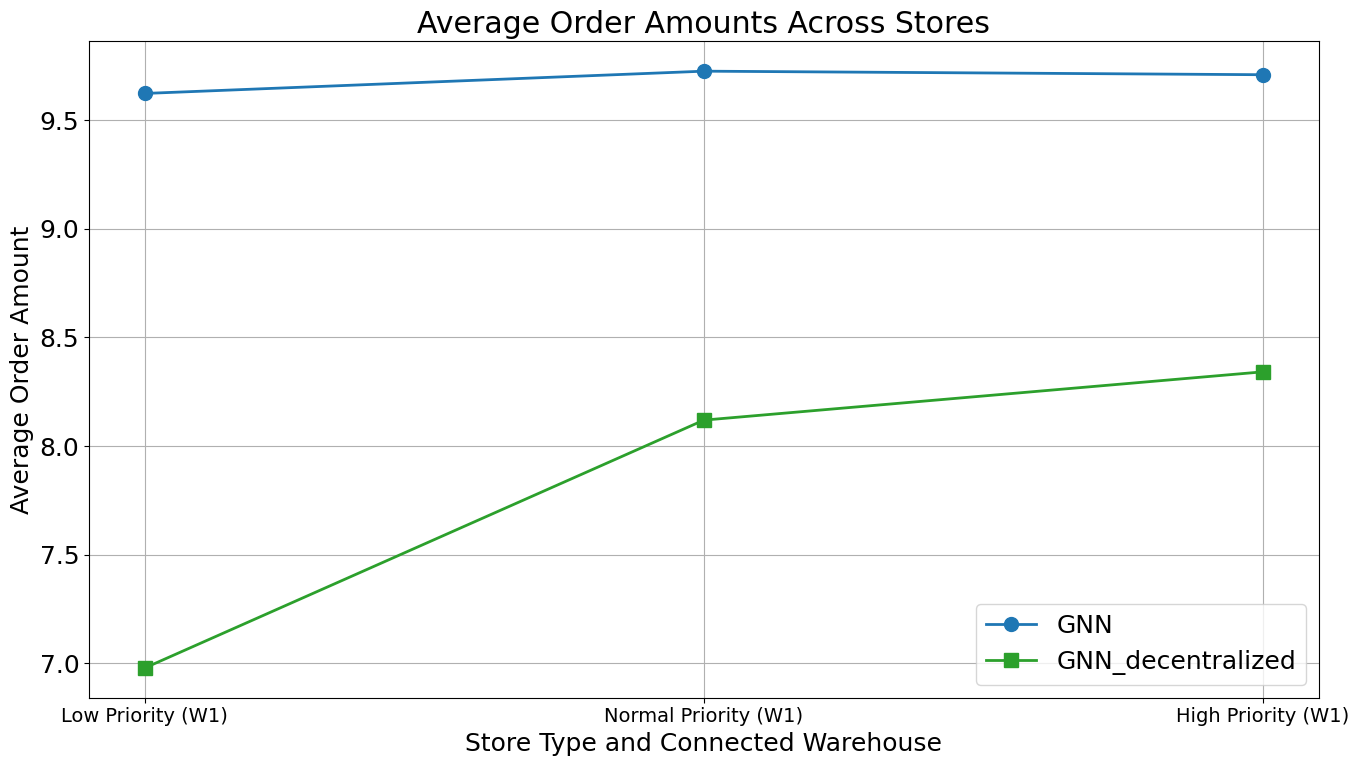


Average Order Amounts by Architecture and Store:
                   Low Priority (W1)  Normal Priority (W1)  High Priority (W1)
GNN                             9.62                  9.73                9.71
GNN_decentralized               6.98                  8.12                8.34


In [9]:
arch_names = ['GNN', 'GNN_decentralized']
markers = ['o', 's', '^', 'x']  # Circle, square, triangle, x

n_stores = 3
n_warehouses = 1
plt.figure(figsize=(14, 8))

inventories_dict = {}

# Define store labels
store_labels = [
    'Low Priority (W1)',
    'Normal Priority (W1)', 
    'High Priority (W1)',
]
for arch_name, marker in zip(arch_names, markers):
    target_data = data[arch_names.index(arch_name)]
    n_periods = len(target_data) // sample_size
    
    store_inventories = [[] for _ in range(n_stores)]
    for store_idx in range(n_stores):
        period_indices = np.arange(sample_size, len(target_data))
        inventories = target_data[f's_{store_idx}_w_0_order'].iloc[period_indices].values
        store_inventories[store_idx].extend(inventories)
    store_inventories_result = [np.mean(store_inventories[i]) for i in range(n_stores)]
    inventories_dict[arch_name] = store_inventories_result
    
    plt.plot(range(n_stores), store_inventories_result, marker=marker,
             color=color_scheme[arch_name], linewidth=2, markersize=10,
             label=arch_name)

plt.xlabel('Store Type and Connected Warehouse')
plt.ylabel('Average Order Amount')
plt.title('Average Order Amounts Across Stores')
plt.grid(True)
plt.legend(loc='best')
plt.xticks(range(n_stores), store_labels, fontsize=14)
plt.tight_layout()
plt.show()
# Create and display pandas DataFrame of order amounts
df_result = pd.DataFrame(inventories_dict, index=store_labels).round(2).T
print("\nAverage Order Amounts by Architecture and Store:")
print(df_result.to_string())

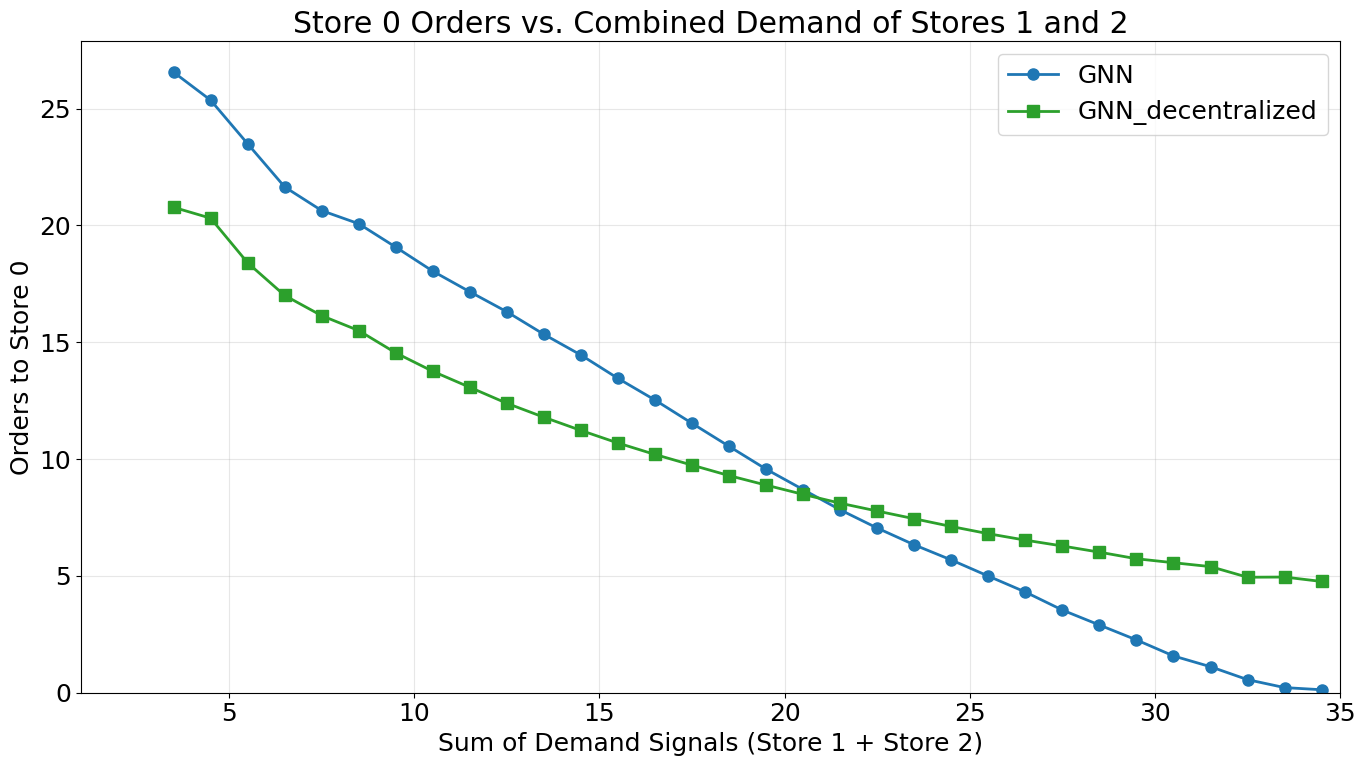

In [12]:
arch_names = ['GNN', 'GNN_decentralized']
markers = ['o', 's']  # Circle, square

plt.figure(figsize=(14, 8))

# Define bin edges for demand values
bin_min = 1
bin_max = 35
bin_step = 1
bin_edges = np.arange(bin_min, bin_max + bin_step, bin_step)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create binned plot comparing sum of demand signals vs. orders to store 0
batch_size = 8192
for arch_idx, arch_name in enumerate(arch_names):
    target_data = data[arch_idx]
    period_indices = np.arange(0, len(target_data) - 1 * batch_size)
    
    # Get demand signals for stores 1 and 2 (for the next period), and orders for store 0
    demand_store1 = target_data[f's_1_demand_signal'].iloc[period_indices + 1 * batch_size].values
    demand_store2 = target_data[f's_2_demand_signal'].iloc[period_indices + 1 * batch_size].values
    orders_store0 = target_data[f's_0_w_0_order'].iloc[period_indices].values

    # demand_store1 = target_data[f's_1_demand'].iloc[period_indices].values
    # demand_store2 = target_data[f's_2_demand'].iloc[period_indices].values
    # orders_store0 = target_data[f's_0_inventory_0'].iloc[period_indices].values
    
    # Calculate sum of demand signals for stores 1 and 2
    combined_demand = demand_store1 + demand_store2
    
    # Calculate mean order amount for each bin
    binned_means = []
    for i in range(len(bin_edges) - 1):
        bin_mask = (combined_demand >= bin_edges[i]) & (combined_demand < bin_edges[i+1])
        if np.any(bin_mask):
            binned_means.append(np.mean(orders_store0[bin_mask]))
        else:
            binned_means.append(np.nan)
    
    # Plot the binned means
    plt.plot(bin_centers, binned_means, marker=markers[arch_idx], 
            color=color_scheme[arch_name], markersize=8, 
            label=arch_name, linewidth=2)

plt.xlabel('Sum of Demand Signals (Store 1 + Store 2)')
plt.ylabel('Orders to Store 0')
plt.title('Store 0 Orders vs. Combined Demand of Stores 1 and 2')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Set reasonable axis limits based on the data
plt.xlim(bin_min, bin_max)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()